In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor

import numpy
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as npr
import random

In [2]:
myseed = 20

torch.manual_seed(myseed)
random.seed(myseed)
npr.seed(myseed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
input_size = 28*56
output_size = 100
BATCH_SIZE = 10

classNames = [j for j in range(100)]

In [4]:
mnist_train = DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=ToTensor()))

train_set, val_set = random_split(mnist_train.dataset, [54000, 6000])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)

test_loader = DataLoader(
    datasets.MNIST('./data', train=False, download=True,
                   transform=ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True)

In [5]:
def pair(single_data, single_target):
    pair_data = []
    pair_target = []

    for i in range(BATCH_SIZE):
        for j in range(BATCH_SIZE):
            pair_data.append(torch.cat((single_data[i], single_data[j]), 2))
            pair_target.append(torch.tensor(int(int(single_target[i])*10 + int(single_target[j]))))
    
    return torch.stack(pair_data), torch.stack(pair_target)

In [6]:
for idx, (data, label) in enumerate(train_loader):
    tensor_image, tensor_target = pair(data, label)
    break

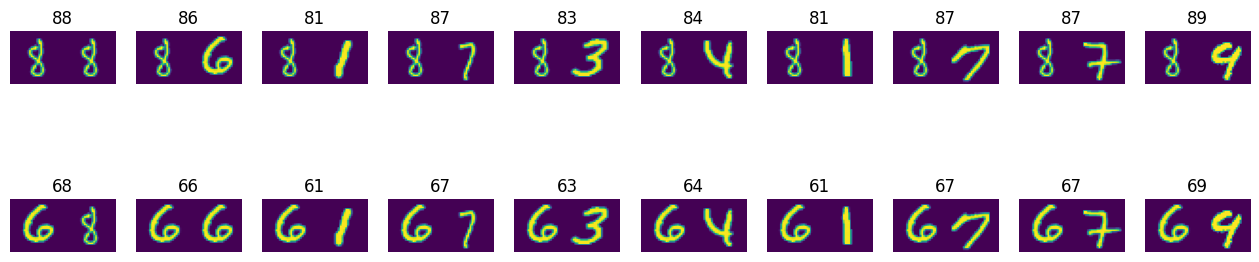

In [7]:
def imshow(img, plot):
    npimg = img.numpy()   # convert from tensor
    plot.imshow(numpy.transpose(npimg, (1, 2, 0))) 

plt.figure(figsize=(16, 4))

for i in range(20):
    image = tensor_image[i]
    label = tensor_target[i].item()
    plt.subplot(2, 10, i + 1)

    imshow(image,plt)
    plt.axis('off')
    plt.title(classNames[label])

In [8]:
class FC2Layer(nn.Module):
    def __init__(self, input_size, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, 250),
            nn.ReLU(),
            nn.Linear(250, 250),
            nn.ReLU(),
            nn.Linear(250, 200),
            nn.ReLU(),
            nn.Linear(200, output_size),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)

In [9]:
accuracy_list = []

def train(epoch, model, optimizer):
    model.train()
    correct = 0
    for batch_id, (data, target) in enumerate(train_loader):
        data, target = pair(data, target)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

    print("Epoch: {}\nTrain Set Accuracy: {:.0f}%".format(epoch, 10*correct/len(train_loader.dataset)))

def test(model, dataset):
    model.eval()
    test_loss = 0
    correct = 0

    for data, target in dataset:
        data, target = pair(data, target)
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(dataset.dataset)
    accuracy = 10*correct/len(dataset.dataset)
    accuracy_list.append(accuracy)

    print('Test set Accuracy: {:.0f}%\n'.format(accuracy))

def get_n_params(model):
    np = 0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

In [10]:
print("Training on", device)

model_fnn = FC2Layer(input_size, output_size)
model_fnn.to(device)

optimizer = optim.SGD(model_fnn.parameters(), lr = 0.1)
print("Number of parameters: {}\n".format(get_n_params(model_fnn)))

for epoch in range(10):
    train(epoch, model_fnn, optimizer)
    test(model_fnn, val_loader)

Training on cuda
Number of parameters: 525300

Epoch: 0
Train Set Accuracy: 74%
Test set Accuracy: 90%

Epoch: 1
Train Set Accuracy: 91%
Test set Accuracy: 93%

Epoch: 2
Train Set Accuracy: 93%
Test set Accuracy: 93%

Epoch: 3
Train Set Accuracy: 95%
Test set Accuracy: 94%

Epoch: 4
Train Set Accuracy: 96%
Test set Accuracy: 95%

Epoch: 5
Train Set Accuracy: 96%
Test set Accuracy: 94%

Epoch: 6
Train Set Accuracy: 97%
Test set Accuracy: 95%

Epoch: 7
Train Set Accuracy: 97%
Test set Accuracy: 96%

Epoch: 8
Train Set Accuracy: 97%
Test set Accuracy: 95%

Epoch: 9
Train Set Accuracy: 98%
Test set Accuracy: 96%



In [11]:
test(model_fnn, test_loader)

Test set Accuracy: 96%

